Model saved to ../Model_1/knn_rf_classifier_0.joblib


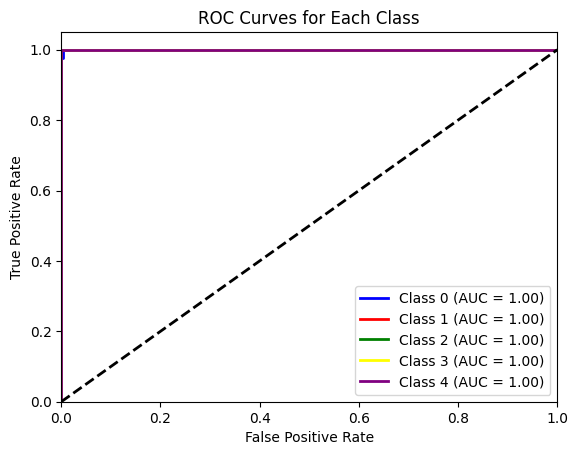

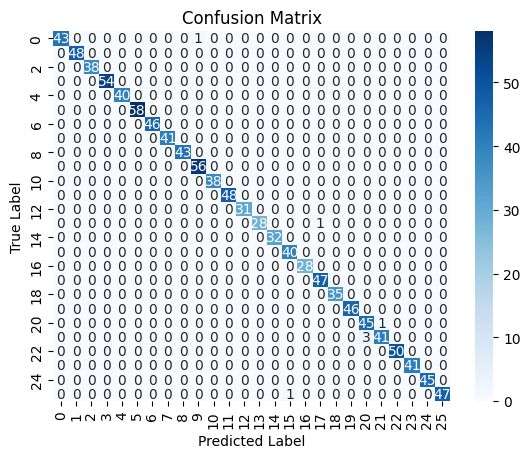

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        44
           1       1.00      1.00      1.00        48
           2       1.00      1.00      1.00        38
           3       1.00      1.00      1.00        54
           4       1.00      1.00      1.00        40
           5       1.00      1.00      1.00        58
           6       1.00      1.00      1.00        46
           7       1.00      1.00      1.00        41
           8       1.00      1.00      1.00        43
           9       0.98      1.00      0.99        56
          10       1.00      1.00      1.00        38
          11       1.00      1.00      1.00        48
          12       1.00      1.00      1.00        31
          13       1.00      0.97      0.98        29
          14       1.00      1.00      1.00        32
          15       0.98      1.00      0.99        40
          16       1.00      1.00      1.00        28
    

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from joblib import dump, load
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib

# Define the custom classifier combining KNN and RandomForest
class KNNtoRFClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=3, **rf_params):
        self.n_neighbors = n_neighbors
        self.knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        self.rf = RandomForestClassifier(**rf_params)
        self.y_train_ = None

    def fit(self, X, y):
        self.knn.fit(X, y)
        self.y_train_ = y
        _, neigh_ind = self.knn.kneighbors(X)
        neigh_labels = y[neigh_ind]
        neigh_labels_flat = neigh_labels.flatten().reshape(-1, self.n_neighbors)
        X_train_rf = np.hstack((X, neigh_labels_flat))
        self.rf.fit(X_train_rf, y)
        return self

    def predict(self, X):
        _, neigh_ind = self.knn.kneighbors(X)
        neigh_labels = self.y_train_[neigh_ind]
        neigh_labels_flat = neigh_labels.flatten().reshape(-1, self.n_neighbors)
        X_rf = np.hstack((X, neigh_labels_flat))
        return self.rf.predict(X_rf)

    def predict_proba(self, X):
        _, neigh_ind = self.knn.kneighbors(X)
        neigh_labels = self.y_train_[neigh_ind]
        neigh_labels_flat = neigh_labels.flatten().reshape(-1, self.n_neighbors)
        X_rf = np.hstack((X, neigh_labels_flat))
        return self.rf.predict_proba(X_rf)

# Load data
data_path = '../datasets/keypoint_for_train_val.csv'
data = pd.read_csv(data_path, header=None)
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the combined model
model = KNNtoRFClassifier()
model.fit(X_train, y_train)


# Assuming X_train, y_train, X_test, y_test are properly defined
knn_rf_model = KNNtoRFClassifier(n_neighbors=3, n_estimators=300, max_depth=30, max_features="sqrt", min_samples_leaf=1, min_samples_split=5, random_state=42)
knn_rf_model.fit(X_train, y_train)

# Save the model
model_path = '../Model_1/knn_rf_classifier_0.joblib'
dump(knn_rf_model, model_path)
print(f"Model saved to {model_path}")

# Load the model for prediction
loaded_model = load(model_path)
predictions = loaded_model.predict(X_test)
probabilities = loaded_model.predict_proba(X_test)

# Plotting ROC curves
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'red', 'green', 'yellow', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix and classification report
cnf_matrix = confusion_matrix(y_test, predictions)
plt.figure()
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_test, predictions))

# Print accuracy
accuracy = np.mean(predictions == y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Validation Accuracy on Refinement Dataset: 0.9947322212467077
Classification Report on Refinement Dataset:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        52
         1.0       1.00      1.00      1.00        58
         2.0       1.00      1.00      1.00        37
         3.0       1.00      0.98      0.99        60
         4.0       1.00      1.00      1.00        54
         5.0       1.00      1.00      1.00        60
         6.0       1.00      1.00      1.00        59
         7.0       1.00      1.00      1.00        13
         8.0       1.00      1.00      1.00        59
         9.0       1.00      1.00      1.00        60
        10.0       1.00      1.00      1.00        59
        11.0       1.00      1.00      1.00        20
        12.0       0.97      0.97      0.97        38
        13.0       0.97      1.00      0.99        38
        14.0       1.00      1.00      1.00        18
        15.0       1.00     

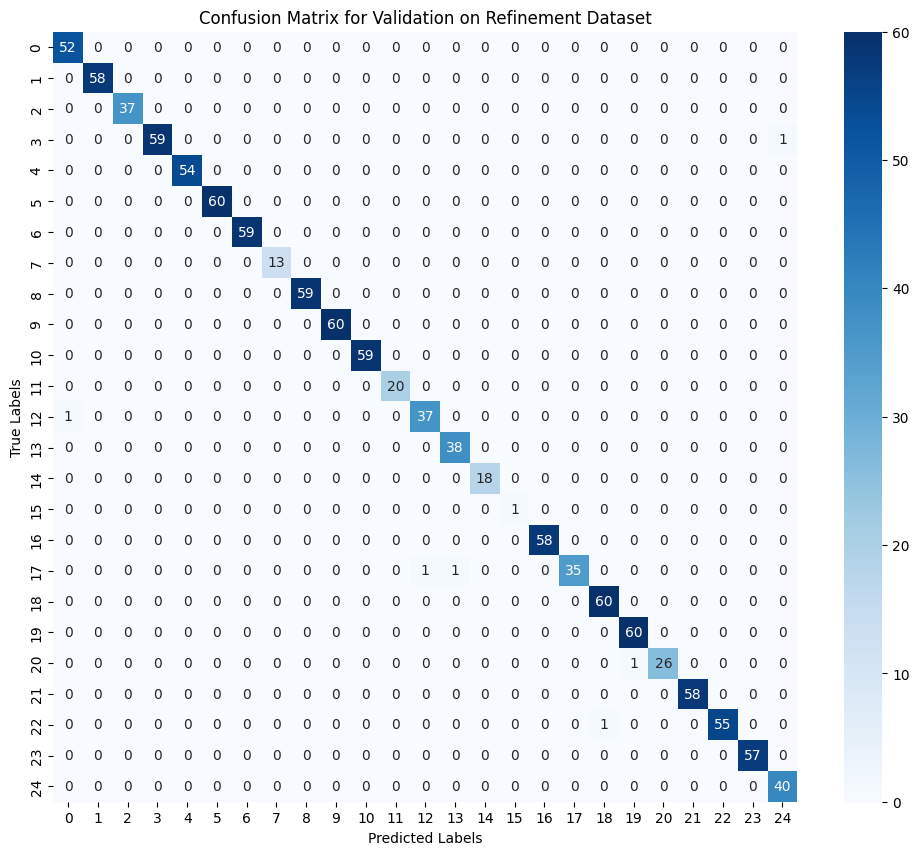

Error Analysis Data:
          label  feature_1  feature_2  feature_3  feature_4  feature_5  \
count   5.00000        5.0        5.0   5.000000   5.000000   5.000000   
mean   15.80000        0.0        0.0   0.118279  -0.185448   0.197411   
std     8.01249        0.0        0.0   0.197736   0.159123   0.368608   
min     2.00000        0.0        0.0  -0.197183  -0.412698  -0.246479   
25%    18.00000        0.0        0.0   0.116788  -0.253521   0.015873   
50%    18.00000        0.0        0.0   0.126984  -0.189781   0.065693   
75%    18.00000        0.0        0.0   0.204225  -0.042254   0.507042   
max    23.00000        0.0        0.0   0.340580  -0.028986   0.644928   

       feature_6  feature_7  feature_8  feature_9  ...  feature_33  \
count   5.000000   5.000000   5.000000   5.000000  ...    5.000000   
mean   -0.458318   0.205162  -0.637563   0.172017  ...    0.009450   
std     0.268599   0.465939   0.341811   0.568012  ...    0.278102   
min    -0.777778  -0.206349  -0.

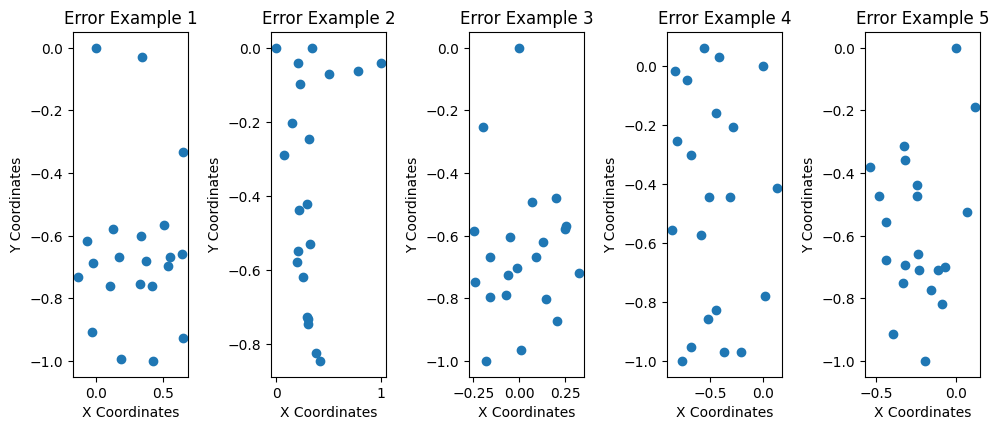

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load

# Load the trained combined model
combined_model = load('../Model_1/knn_rf_classifier_0.joblib')

# Load the refinement dataset
data_path = '../datasets/refinement_for_model_1.csv'
refinement_data = pd.read_csv(data_path, header=None)
columns = ['label'] + [f'feature_{i}' for i in range(1, refinement_data.shape[1])]
refinement_data.columns = columns

X_refinement = refinement_data.drop('label', axis=1).values
y_refinement = refinement_data['label'].values

# Make predictions using the combined model
y_pred_refinement = combined_model.predict(X_refinement)
probabilities = combined_model.predict_proba(X_refinement).max(axis=1)  # get the maximum probability

# Define confidence threshold
confidence_threshold = 0.5
needs_iteration = probabilities < confidence_threshold

# Output the accuracy and the classification report
test_accuracy_refinement = accuracy_score(y_refinement, y_pred_refinement)
print("Validation Accuracy on Refinement Dataset:", test_accuracy_refinement)
print("Classification Report on Refinement Dataset:")
print(classification_report(y_refinement, y_pred_refinement))

# Check for iteration need
if needs_iteration.any():
    print("Need iteration for this model.")
    # Save cases that need iteration
    refinement_data[needs_iteration].to_csv('../datasets/datasets_iteration/refinement_for_iteration_0.csv', index=False)

# Confusion matrix visualization
cm = confusion_matrix(y_refinement, y_pred_refinement)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Validation on Refinement Dataset')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Error analysis
if needs_iteration.any():
    error_indices = np.where(needs_iteration)[0]
    error_analysis_data = refinement_data.iloc[error_indices]
    print("Error Analysis Data:")
    print(error_analysis_data.describe(include='all'))
    
    # Plot error analysis - example scatter plot of features
    plt.figure(figsize=(10, 8))
    for i in range(min(len(error_indices), 10)):  # Plot up to 10 error examples
        plt.subplot(2, 5, i+1)
        example_data = error_analysis_data.iloc[i, 1:].values.reshape(-1, 2)
        plt.scatter(example_data[:, 0], example_data[:, 1], marker='o')
        plt.title(f"Error Example {i+1}")
        plt.xlabel('X Coordinates')
        plt.ylabel('Y Coordinates')
    plt.tight_layout()
    plt.show()
